<a href="https://colab.research.google.com/github/CoderSsVartak/Image-Reconstruction/blob/master/image_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Total epochs = 100, batch_size = 16
# T1 = 2700, T2 = 300, T3 = 12,000
# 1st 18 epochs, train generator only using MSE loss. next 2 epochs, train only discriminator using discriminator loss
# Remaining 80 epochs, train both using generator and discriminator loss
# Increase training set to 600 images, test set to 30 images and reduce percent mask to 50%, 

import os
import time
import random
import datetime
import pytz

#Image manipulation packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#Tensorflow models libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Conv2DTranspose, Flatten, Dense
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.applications import VGG19
#Alternative of pickle for larger files
import joblib
import pickle

#packages required to get the data uploaded on the drive
from googleapiclient.http import MediaIoBaseDownload
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
from google.colab import drive
import io
import random

In [ ]:
# Google Drive API Code to authenticate access to your google acount drive that has the dataset in it
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#Code to load images from Drive
def load_drive_data(file_id):

    drive_service = build('drive', 'v3')
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()

    downloaded.seek(0)

    # Joblib is used because of large file size
    f = joblib.load(downloaded)

    return f

#images downloaded are in the form of a dictionary, convert it to a numpy array
def dict_to_array(images):

    image_list = []
    for persons in images.keys():
        image_list.append(images[persons])
    
    return np.array(image_list)

#function to plot multiple images
def plot(images, figsize=(10, 10)):

    plt.figure(figsize=figsize)
    
    for index, image in enumerate(images):
        # display original
        ax = plt.subplot(2, len(images), index + 1)
        plt.imshow(image.reshape(image.shape[0], image.shape[1], image.shape[2]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
# images obtained are in the form of a dictionary and have values between 0-1, and are cropped so as to obtain just the facial images
# dictionary[person] = image_value

# Data description: Total facial images of 105 people with each person having a total of 6 images
# Input given is the file id of the file stored in drive
data_key = '1QZv7mWvvF8mnT0A2mA4OFSvxF1eqPd8g'

image_data = load_drive_data(data_key)
images = dict_to_array(image_data)

# Create data copy to local storage, can be accessed directly from there
with open('image_data.pickle', 'wb') as file:
    joblib.dump(images, file)

# Load the test set images required
# with open('/content/image_data.pickle', 'rb') as file:
#     images = joblib.load(file)

In [ ]:
del (image_data)
images.shape

(630, 224, 224, 3)

In [ ]:
# Block a % of image visible
# percent_mask is in the range 0 - 1
def create_masked_images(images, **kwargs):

    mask_shape = images.shape

    # default value for percentage of image to be masked
    percent_mask = 0.5
    if 'percent_mask' in kwargs:
        percent_mask = kwargs['percent_mask']

    # hide_axis = 2 => row axis
    hide_axis = 2
    if 'hide_axis' in kwargs:
        hide_axis = kwargs['hide_axis']
    
    # Always the 2nd axis ie columns are masked
    zero_shape = int(mask_shape[hide_axis]*percent_mask)//2
    one_shape = mask_shape[hide_axis] - zero_shape*2

    if 'partial_image' in kwargs:

        print("Hidden pixels and Visible Pixels Count: ",zero_shape, one_shape)
        # print(images[:, :, zero_shape: one_shape+zero_shape, :].shape)
        return images[:, :, zero_shape: one_shape+zero_shape, :]
    
    if hide_axis == 1:
        zero_shape = (mask_shape[0], zero_shape, mask_shape[2], mask_shape[3])
        one_shape = (mask_shape[0], one_shape, mask_shape[2], mask_shape[3])
    
    else:
        zero_shape = (mask_shape[0], mask_shape[1], zero_shape, mask_shape[3])
        one_shape = (mask_shape[0], mask_shape[1], one_shape, mask_shape[3])

    mask = np.concatenate((np.zeros(zero_shape), np.ones(one_shape), np.zeros(zero_shape)), axis=hide_axis)
    
    if 'show_boundary' in kwargs and kwargs['show_boundary']:
        mask_compliment = 1 - mask
        return mask*images + np.mean(images)*mask_compliment

    return mask*images, mask[0]


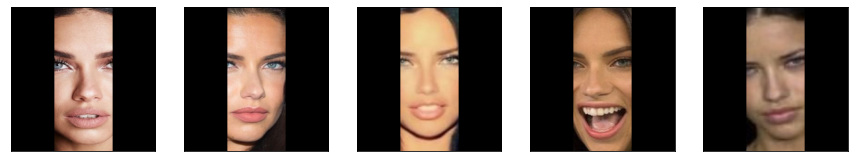

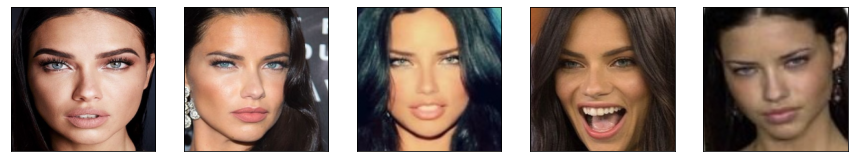

In [ ]:
plot(create_masked_images(images[0: 5], percent_mask = 0.6, hide_axis=2)[0], figsize=(15, 15))
plot(images[0: 5], figsize=(15, 15))

In [ ]:
# Initially 60% image is masked, 530 for training and 100 for testing.
# Reduce masking size if network doesnt optimize

In [ ]:
masked_images, mask = create_masked_images(images, percent_mask = 0.6, hide_axis=2)

In [ ]:
masked_images.shape, mask.shape

((630, 224, 224, 3), (224, 224, 3))

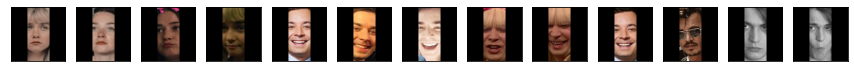

In [ ]:
start, end = 290, 303
plot(masked_images[start: end], figsize=(15, 15))

In [ ]:
# https://towardsdatascience.com/hitchhikers-guide-to-residual-networks-resnet-in-keras-385ec01ec8ff

def image_generator(image_shape):

    input_img = Input(shape=(224, 224, 3), dtype='float32')

    x = Conv2D(64, (5, 5), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(input_img)
    x = Conv2D(128, (3, 3), strides=2, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(2, 2), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(4, 4), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(8, 8), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    
    x = Conv2DTranspose(128, (4, 4), strides=2, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(3, (3, 3), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(x)

    return Model(input_img, x, name='Generator')


def image_discriminator(image_shape):

    input_img = Input(shape=image_shape, dtype='float32')

    x = Conv2D(32, (5, 5), strides=2, activation='relu', padding='same')(input_img)
    x = Conv2D(64, (5, 5), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(64, (5, 5), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(64, (5, 5), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(64, (5, 5), strides=2, activation='relu', padding='same')(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model(input_img, x, name='Discriminator')


    

In [ ]:
gen_model = image_generator((224, 224, 3))
gen_model.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 256)     295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 256)     590080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 256)     590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 256)     59

In [ ]:
disc_model = image_discriminator(image_shape=(224, 224, 3))
disc_model.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 112, 112, 32)      2432      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 56, 56, 64)        51264     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 64)        102464    
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 64)        102464    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 64)          102464    
_________________________________________________________________
flatten (Flatten)            (None, 3136)            

In [ ]:
# Loss functions

def mse(y_true, y_pred):
    return tf.reduce_mean(tf.losses.mean_squared_error(y_true, y_pred))

def cosine_sim(y_true, y_pred):
    return tf.reduce_mean(tf.abs(tf.losses.cosine_similarity(tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32))))

# y_true is the output of the discriminator for actual images
# y_pred is the output of the discriminator for generator generated images

def discriminator_loss(y_true, y_pred, epsilon=1e-7):
    return -tf.reduce_mean(tf.math.log(tf.maximum(y_true, epsilon)) + tf.math.log(tf.maximum(1-y_pred, epsilon)))


# y_true is the actual image
# y_pred is the Generator generated image
# discriminator_pred is the output of the discriminator when given image generated by the generator
# alpha is used as a control variable to determine the importance of mse loss
def generator_loss(y_true, y_pred, discriminator_pred, mask_compliment, alpha=0.0004, epsilon=1e-7):
    return mse(y_true, y_pred) - alpha*tf.reduce_mean(tf.math.log(tf.maximum(discriminator_pred, epsilon)))


#Tensorflow function to find psnr and rmse of an image
def psnr(y_true, y_pred):
    return tf.math.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1, name=None))

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean((y_true - y_pred)**2))



In [ ]:
def save_models(generator, discriminator, gen_filename='', disc_filename=''):

    save_model(generator, gen_filename)
    save_model(discriminator, disc_filename)


# To save the new logs
def save_logs(logs, previous_logs=None, logfile_name='', keys=None):

    temp = {}
    if previous_logs and keys:

        for key in keys:
            temp[key] = previous_logs[key] + logs[key]
    
    else:
        temp = logs
    
    with open(logfile_name, 'wb') as file:
        pickle.dump(temp, file)
    
    return True
        
# Load the logfile
def load_logs(logfile_name=None):

    if logfile_name:
        try:
            with open(logfile_name, 'rb') as file:
                temp_logs = pickle.load(file)

            print("Log file loaded in the form of a dictionary")

            return temp_logs

        except FileNotFoundError:
            print("No log file created, Returned an empty dictionary")
            return {}
            
    return False

In [ ]:
# https://keras.io/guides/writing_a_training_loop_from_scratch/
# pass pre compiled generator and discriminator models as input to the function

# kwargs can contain train_data = (masked_images, actual_images), test_data = (masked_test, actual_test),
#                    epochs, batch_size, 
#                    train_disc_after,
#                    loss=(gen_loss_function, disc_loss_function),
#                    optimizer = (gen_optimizer, disc_optimizer)
#                    mask_compliment, accuracy_function,
#                    save_after, save_model

def train(gen_model, disc_model, **kwargs):

    test_present = True if 'test_data' in kwargs else False

    if 'train_data' in kwargs:
        masked_images, actual_images = kwargs['train_data'][0], kwargs['train_data'][1]

    if 'test_data' in kwargs:
        masked_test, actual_test = kwargs['test_data'][0], kwargs['test_data'][1]  

    # Default epoch count
    epochs, epochs_done = 100, 0
    if 'epochs' in kwargs:
        total_epochs, phase_1, phase_2  = kwargs['epochs']
        epochs_done = kwargs['epochs_done']
    
    # Default batch_size value
    batch_size = 32
    if 'batch_size' in kwargs:
        batch_size = kwargs['batch_size']

    if 'loss' in kwargs:
        gen_loss_function, disc_loss_function = kwargs['loss'][0], kwargs['loss'][1]

    if 'optimizer' in kwargs:
        gen_optimizer, disc_optimizer = kwargs['optimizer'][0], kwargs['optimizer'][1]
    
    if 'mask_compliment' in kwargs:
        mask_compliment = kwargs['mask_compliment']
    
    if 'metric' in kwargs:
        accuracy = kwargs['metric']

    if 'mse' in kwargs:
        mse_error = kwargs['mse']
    
    save_after = 10
    if 'save_after' and 'save_models' in kwargs:
        save_after = kwargs['save_after']
        save = kwargs['save_models']
        
    if 'history' and 'save_logs' in kwargs:
        history = kwargs['history']
        save_logs = kwargs['save_logs']
        

    # List to store the loss and accuracy values after each epochs
    global gen_losses, disc_losses, test_gen_losses, test_disc_losses
    global gen_accuracy, test_gen_accuracy
    global temp_history

    gen_losses, disc_losses, gen_accuracy, temp_history = [], [], [], {}
    test_gen_losses, test_disc_losses, test_gen_accuracy = [], [], []
    
    # Train for desired number of epochs
    for step in range(total_epochs-epochs_done):
        
        # Shuffle the dataset at the start of each epoch
        masked_images, actual_images = shuffle(masked_images, actual_images)

        # Print which phase is the training going on
        if epochs_done + step == 0:
            print("----------------Starting Phase 1----------------")
        elif epochs_done + step == phase_1:
            print("----------------Starting Phase 2----------------")
        elif epochs_done + step == phase_1 + phase_2:
            print("----------------Starting Phase 3----------------")

        print(f'Epoch {epochs_done+step+1}/{epochs}', end='\n[')
        start_time = time.time()

        # Generator & Discriminator Loss and accuracy trackers for each epochs
        gen_loss, gen_acc = 0, 0
        disc_loss = 0

        # Loss alters after phase 1, so variable to change the name of the loss 
        gen_loss_name = 'MSE'
        if epochs_done + step >= phase_1:
            gen_loss_name = 'altered_MSE'

            
        # train on batch data
        batch_steps = masked_images.shape[0]//batch_size
        for batch_step in range(batch_steps):
            
            # Generator & Discriminator Loss and accuracy trackers for each batch
            gen_batch_loss, disc_batch_loss = 0, 0
            gen_batch_acc = 0
            start, end = batch_step*batch_size, (batch_step+1)*batch_size
            
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                
                # Generator applied to masked images
                gen_train = gen_model(masked_images[start: end], training=True)
                
                # Discriminator makes prediction on both masked and actual images
                disc_masked = disc_model(gen_train, training=True)
                disc_actual = disc_model(actual_images[start: end], training=True)
                

                y_true = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)
                y_pred = tf.concat([disc_masked, disc_actual], axis=0)

                # Generator accuracy
                gen_batch_acc = accuracy(actual_images[start: end], gen_train)

                # Phase 1: Compute Loss for both Generator and Discriminator
                if epochs_done + step < phase_1:
                    gen_batch_loss = mse_error(actual_images[start: end], gen_train)
                    disc_batch_loss = tf.reduce_mean(disc_loss_function(y_true, y_pred))
                
                # Phase 2: Compute loss for both Generator and Discriminator
                elif epochs_done + step < phase_1 + phase_2:
                    gen_batch_loss = mse_error(actual_images[start: end], gen_train)
                    disc_batch_loss = tf.reduce_mean(disc_loss_function(y_true, y_pred))

                # Phase 3: Computer altered loss for Generator and loss for Discriminator
                else:
                    # Find out loss for phase 3
                    gen_batch_loss = gen_loss_function(actual_images[start: end], gen_train, disc_masked, mask_compliment)
                    disc_batch_loss = tf.reduce_mean(disc_loss_function(y_true, y_pred))

                # Add batch loss to the epoch loss
                gen_loss += gen_batch_loss
                disc_loss += disc_batch_loss    
                gen_acc += gen_batch_acc
            

            # Phase 1: Train only Generator on MSE loss
            if epochs_done + step < phase_1:
                gen_grads = gen_tape.gradient(gen_batch_loss, gen_model.trainable_weights)
                gen_optimizer.apply_gradients(zip(gen_grads, gen_model.trainable_weights))

            # Phase 2: Train only Discriminator
            elif epochs_done + step < phase_1 + phase_2:
                disc_grads = disc_tape.gradient(disc_batch_loss, disc_model.trainable_weights)
                disc_optimizer.apply_gradients(zip(disc_grads, disc_model.trainable_weights))
            
            # Phase 3: Train both Generator and Discriminator, Generator -> Altered_MSE losss
            else:
                gen_grads = gen_tape.gradient(gen_batch_loss, gen_model.trainable_weights)
                gen_optimizer.apply_gradients(zip(gen_grads, gen_model.trainable_weights))
                

                if 'train_disc_after' in kwargs:
                    if batch_step % kwargs['train_disc_after'] == 0:
                        disc_grads = disc_tape.gradient(disc_batch_loss, disc_model.trainable_weights)
                        disc_optimizer.apply_gradients(zip(disc_grads, disc_model.trainable_weights))
                
                else:
                    disc_grads = disc_tape.gradient(disc_batch_loss, disc_model.trainable_weights)
                    disc_optimizer.apply_gradients(zip(disc_grads, disc_model.trainable_weights))
                    

            if batch_step % 5 == 0:
                print('=', end='')
        
        print(']', end='  ')
        # Add mean of batch_losses into loss_list
        gen_losses.append(gen_loss/batch_steps)
        disc_losses.append(disc_loss/batch_steps)

        # Add mean of batch accuracy into accuracy list
        gen_accuracy.append(gen_acc/batch_steps)

        # Calculate the time elapsed for the total epoch
        elapsed_time = time.time() - start_time
        
        # Validation dataset
        if 'test_data' in kwargs:
            test_gen_pred = gen_model(masked_test)
            
            test_disc_masked = disc_model(test_gen_pred)
            test_disc_actual = disc_model(actual_test)
            zeros, ones = tf.zeros((masked_test.shape[0], 1)), tf.ones((actual_test.shape[0], 1))

            test_true, test_pred = tf.concat([zeros, ones], axis=0), tf.concat([test_disc_masked, test_disc_actual], axis=0)

            test_psnr = accuracy_function(actual_test, test_gen_pred)

            # Compute Test loss for Generator
            if epochs_done + step < phase_1 + phase_2:
                test_gen_loss = mse_error(actual_test, test_gen_pred)
            else:
                test_gen_loss = gen_loss_function(actual_test, test_gen_pred, test_disc_masked, mask_compliment)

            # Compute Test loss for Discriminator
            test_disc_loss = tf.reduce_mean(disc_loss_function(test_true, test_pred))

            # Append losses to the loss list
            test_gen_losses.append(test_gen_loss)
            test_disc_losses.append(test_disc_loss)
            test_gen_accuracy.append(test_psnr)
            
            # print Metrics
            print(f'{gen_loss_name} = {gen_loss/batch_steps:.4f}, Disc Loss = {disc_loss/batch_steps:.4f}, PSNR = {gen_acc/batch_steps:.3f}, Test {gen_loss_name} = {test_gen_loss:.4f}, Test Disc Loss = {test_disc_loss:.4f}, Test PSNR = {test_psnr:.3f} ')    

        else:
            print(f'{gen_loss_name} = {gen_loss/batch_steps:.4f}, Disc Loss = {disc_loss/batch_steps:.4f}, PSNR = {gen_acc/batch_steps:.3f}')

        print(f'Time per epoch: {time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}')
        print()

        # save the models and the log files
        if step % save_after == 0 or step == epochs-1:

            save_model(gen_model, f'Generator_{step+1+epochs_done}epochs.h5', include_optimizer=True, save_format='h5')
            save_model(disc_model, f'Discriminator_{step+1+epochs_done}epochs.h5', include_optimizer=True, save_format='h5')
            
            # save(gen_model, disc_model,
            #      gen_filename=f'Generator_{step+1+epochs_done}epochs.h5', 
            #      disc_filename=f'Discriminator_{step+1+epochs_done}epochs.h5')

            if 'history' in kwargs:
                
                # If there are no keys in the logfile
                if history == {}:
                    keys = ['generator_losses', 'disc_losses', 'psnr']
                    
                    if test_present:
                        keys.append('test_generator_losses')
                        keys.append('test_discriminator_losses')
                        keys.append('test_psnr')
                
                else:
                    keys = history.keys()

                if test_present:
                    save_logs(logs={'generator_loss': gen_losses, 'discriminator_loss':disc_losses, 'psnr':gen_accuracy,
                                    'test_generator_loss':test_gen_losses, 'test_discriminator_loss':test_disc_losses, 'test_psnr':test_gen_accuracy},
                            previous_logs=history,
                            logfile_name=f'logs_{step+1+epochs_done}epochs.pickle',
                            keys=keys)

                else:
                    save_logs(logs={'generator_loss': gen_losses, 'discriminator_loss':disc_losses, 'psnr':gen_accuracy},
                              previous_logs=history,
                              logfile_name=f'logs_{step+1+epochs_done}epochs.pickle',
                              keys=keys)

                    
                # Update current logs
                history = load_logs(logfile_name=f'logs_{step+1+epochs_done}epochs.pickle')

                # Display the first 4 examples and its metrics
                if 'plot_function' in kwargs:

                    print("Test Images")
                    kwargs['plot_function'](np.array(test_gen_pred[: 4]), figsize=(15, 15))

                    print("Actual Images")
                    kwargs['plot_function'](np.array(actual_test[: 4]), figsize=(15, 15))

                    print(f"PSNR: {psnr(actual_test[: 4], test_gen_pred[: 4])}")
                    print(f"MSE: {mse(actual_test[: 4], test_gen_pred[: 4])}")
                    print(f'RMSE: {rmse(actual_test[: 4], test_gen_pred[: 4])}')
                    print(f'Cosine Similarity: {cosine_sim(actual_test[: 4], test_gen_pred[: 4])}')
                    print(f'Discriminator Prediction on Generator: {tf.reduce_mean(disc_model.predict(test_gen_pred[: 4]))}')
                    print(f'Discriminator Prediction on Actual: {tf.reduce_mean(disc_model.predict(actual_test[: 4]))}')


            # Reset the losses as they are being saved to avoid repeatation
            gen_losses, disc_losses, gen_accuracy = [], [], []
            test_gen_losses, test_disc_losses, test_gen_accuracy = [], [], []
    
    return history


In [ ]:
# Common parameters for generator and discriminator

# metrics = [tf.metrics.RootMeanSquaredError]
batch_size = 16
lr_rate = 0.001
epochs = (100, 15, 5)
epochs_done = 30
epsilon = 1e-7
save_after = 10
train_disc_after = 1


# Comment the lr_schedule, gen_optimizer and disc_optimizer if model is to be reloaded
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate,
#                                                              decay_steps=10000, 
#                                                              decay_rate=0.96,
#                                                              staircase=True)

gen_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_rate, beta_1 = 0.5, beta_2=0.999, epsilon=epsilon)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_rate, beta_1 = 0.5, beta_2=0.999, epsilon=epsilon)

gen_loss = generator_loss
disc_loss = tf.keras.losses.binary_crossentropy
mse_error = mse

train_data = (masked_images[: 600], images[: 600])
test_data = (masked_images[600: 630], images[600: 630])
loss = (gen_loss, disc_loss)
mask_compliment = 1 - mask
accuracy_function = psnr

logs = load_logs(logfile_name='/logs_31epochs.pickle')
print("Keys in Dictionary: ", logs.keys())
try:
    print("Length: ", len(logs['generator_loss']))
except KeyError:
    pass

Log file loaded in the form of a dictionary
Keys in Dictionary:  dict_keys(['generator_loss', 'discriminator_loss', 'psnr', 'test_generator_loss', 'test_discriminator_loss', 'test_psnr'])
Length:  22


In [ ]:
# Run this cell only if the model is to be trained from the beginning
gen_model.compile(optimizer=gen_optimizer, loss=gen_loss)
disc_model.compile(optimizer=disc_optimizer, loss=disc_loss)

In [ ]:
gen_model = load_model('/Generator_31epochs.h5', custom_objects={'generator_loss': gen_loss})
disc_model = load_model('/Discriminator_31epochs.h5', custom_objects={'discriminator_loss':disc_loss})

gen_optimizer = gen_model.optimizer
disc_optimizer = disc_model.optimizer

Epoch 31/100
[========]  altered_MSE = 0.0380, Disc Loss = 7.6666, PSNR = 14.661, Test altered_MSE = 0.0366, Test Disc Loss = 7.6666, Test PSNR = 14.957 
Time per epoch: 00:10:43



Log file loaded in the form of a dictionary
Test Images


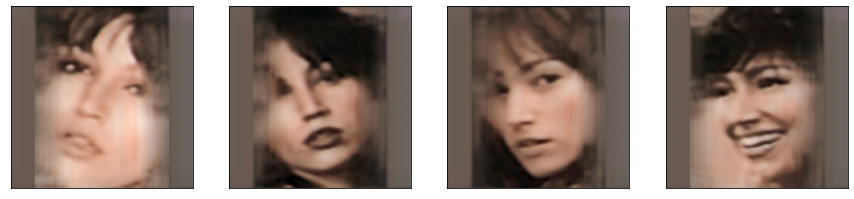

Actual Images


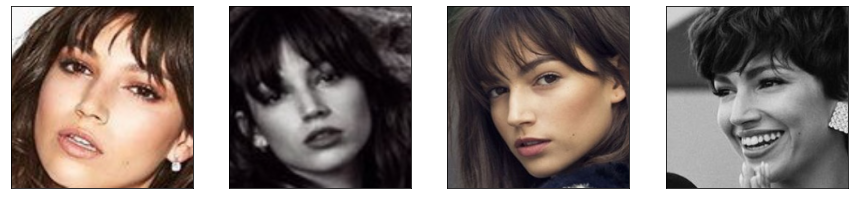

PSNR: 15.451589584350586
MSE: 0.029769841581583023
RMSE: 0.1725393831729889
Cosine Similarity: 0.9820759892463684
Discriminator Prediction on Generator: 1.0
Discriminator Prediction on Actual: 1.0
Epoch 32/100
[========]  altered_MSE = 0.0378, Disc Loss = 7.6666, PSNR = 14.709, Test altered_MSE = 0.0365, Test Disc Loss = 7.6666, Test PSNR = 14.952 
Time per epoch: 00:10:45

Epoch 33/100
[========]  altered_MSE = 0.0380, Disc Loss = 7.6666, PSNR = 14.653, Test altered_MSE = 0.0354, Test Disc Loss = 7.6666, Test PSNR = 15.102 
Time per epoch: 00:10:43

Epoch 34/100
[========]  altered_MSE = 0.0367, Disc Loss = 7.6666, PSNR = 14.820, Test altered_MSE = 0.0365, Test Disc Loss = 7.6666, Test PSNR = 14.929 
Time per epoch: 00:10:45

Epoch 35/100
[========]  altered_MSE = 0.0374, Disc Loss = 7.6666, PSNR = 14.738, Test altered_MSE = 0.0365, Test Disc Loss = 7.6666, Test PSNR = 14.962 
Time per epoch: 00:10:46

Epoch 36/100
[========]  altered_MSE = 0.0484, Disc Loss = 7.6666, PSNR = 13.693, T

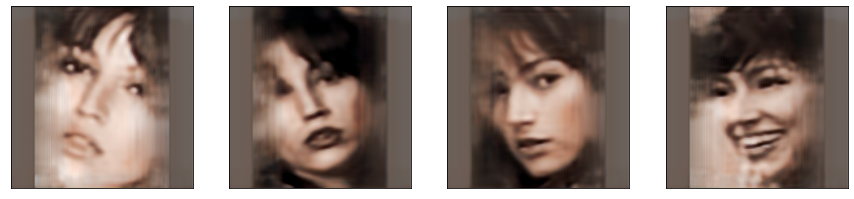

Actual Images


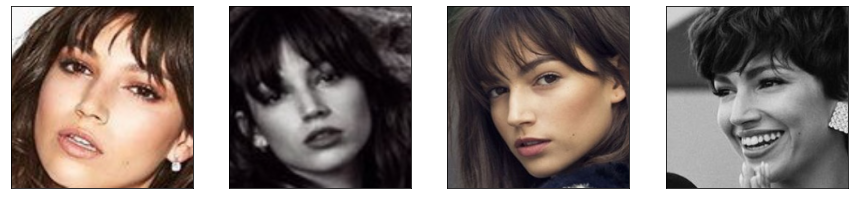

PSNR: 15.544589042663574
MSE: 0.02920433133840561
RMSE: 0.17089274525642395
Cosine Similarity: 0.9738028645515442
Discriminator Prediction on Generator: 1.0
Discriminator Prediction on Actual: 1.0
Epoch 42/100
[========]  altered_MSE = 0.0371, Disc Loss = 7.6666, PSNR = 14.762, Test altered_MSE = 0.0356, Test Disc Loss = 7.6666, Test PSNR = 15.077 
Time per epoch: 00:10:46

Epoch 43/100
[========]  altered_MSE = 0.0383, Disc Loss = 7.6666, PSNR = 14.637, Test altered_MSE = 0.0363, Test Disc Loss = 7.6666, Test PSNR = 14.954 
Time per epoch: 00:10:47

Epoch 44/100
[========]  altered_MSE = 0.0365, Disc Loss = 7.6666, PSNR = 14.859, Test altered_MSE = 0.0362, Test Disc Loss = 7.6666, Test PSNR = 14.904 
Time per epoch: 00:10:47

Epoch 45/100
[========]  altered_MSE = 0.0369, Disc Loss = 7.6666, PSNR = 14.797, Test altered_MSE = 0.0362, Test Disc Loss = 7.6666, Test PSNR = 14.975 
Time per epoch: 00:10:48

Epoch 46/100
[========]  altered_MSE = 0.0364, Disc Loss = 7.6666, PSNR = 14.866, T

Log file loaded in the form of a dictionary
Test Images


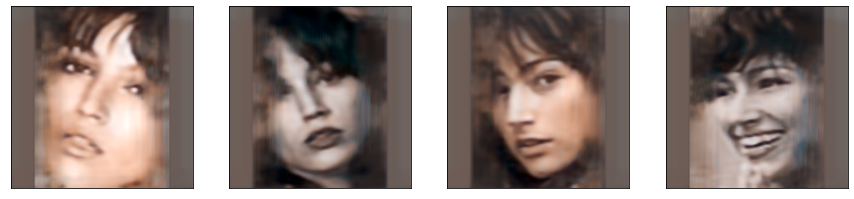

Actual Images


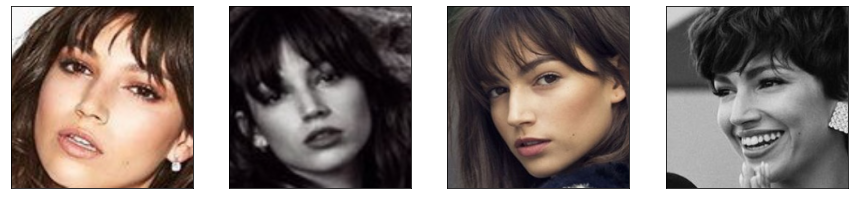

PSNR: 15.710952758789062
MSE: 0.02803238108754158
RMSE: 0.16742874681949615
Cosine Similarity: 0.9824744462966919
Discriminator Prediction on Generator: 1.0
Discriminator Prediction on Actual: 1.0
Epoch 52/100
[========]  altered_MSE = 0.0352, Disc Loss = 7.6666, PSNR = 15.022, Test altered_MSE = 0.0347, Test Disc Loss = 7.6666, Test PSNR = 15.154 
Time per epoch: 00:10:48

Epoch 53/100
[========]  altered_MSE = 0.0348, Disc Loss = 7.6666, PSNR = 15.051, Test altered_MSE = 0.0343, Test Disc Loss = 7.6666, Test PSNR = 15.263 
Time per epoch: 00:10:49

Epoch 54/100
[========]  altered_MSE = 0.0346, Disc Loss = 7.6666, PSNR = 15.086, Test altered_MSE = 0.0346, Test Disc Loss = 7.6666, Test PSNR = 15.250 
Time per epoch: 00:10:50

Epoch 55/100
[========]  altered_MSE = 0.0347, Disc Loss = 7.6666, PSNR = 15.090, Test altered_MSE = 0.0336, Test Disc Loss = 7.6666, Test PSNR = 15.341 
Time per epoch: 00:10:48

Epoch 56/100
[========]  altered_MSE = 0.0345, Disc Loss = 7.6666, PSNR = 15.103, T

Log file loaded in the form of a dictionary
Test Images


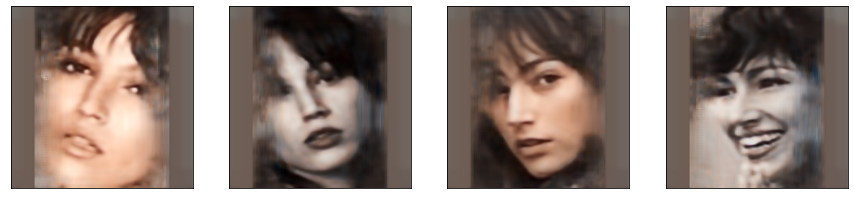

Actual Images


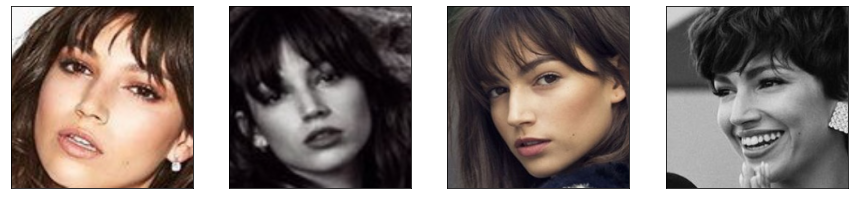

PSNR: 15.67655086517334
MSE: 0.028180718421936035
RMSE: 0.1678711324930191
Cosine Similarity: 0.987464427947998
Discriminator Prediction on Generator: 1.0
Discriminator Prediction on Actual: 1.0
Epoch 62/100
[========]  altered_MSE = 0.0337, Disc Loss = 7.6666, PSNR = 15.200, Test altered_MSE = 0.0347, Test Disc Loss = 7.6666, Test PSNR = 15.138 
Time per epoch: 00:10:48

Epoch 63/100
[========]  altered_MSE = 0.0356, Disc Loss = 7.6666, PSNR = 14.961, Test altered_MSE = 0.0378, Test Disc Loss = 7.6666, Test PSNR = 14.677 
Time per epoch: 00:10:48

Epoch 64/100
[========]  altered_MSE = 0.0341, Disc Loss = 7.6666, PSNR = 15.146, Test altered_MSE = 0.0339, Test Disc Loss = 7.6666, Test PSNR = 15.281 
Time per epoch: 00:10:48

Epoch 65/100
[========]  altered_MSE = 0.0340, Disc Loss = 7.6666, PSNR = 15.165, Test altered_MSE = 0.0346, Test Disc Loss = 7.6666, Test PSNR = 15.197 
Time per epoch: 00:10:50

Epoch 66/100
[========]  altered_MSE = 0.0337, Disc Loss = 7.6666, PSNR = 15.215, Tes

Log file loaded in the form of a dictionary
Test Images


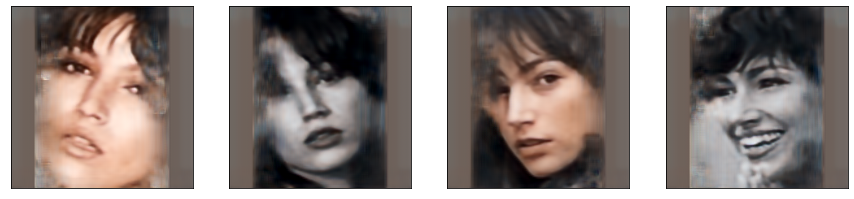

Actual Images


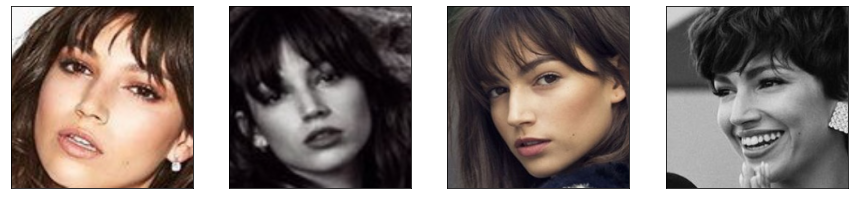

PSNR: 15.651657104492188
MSE: 0.02837550640106201
RMSE: 0.16845031082630157
Cosine Similarity: 0.9794814586639404
Discriminator Prediction on Generator: 1.0
Discriminator Prediction on Actual: 1.0
Epoch 72/100
[========]  altered_MSE = 0.0328, Disc Loss = 7.6666, PSNR = 15.305, Test altered_MSE = 0.0351, Test Disc Loss = 7.6666, Test PSNR = 15.174 
Time per epoch: 00:10:50

Epoch 73/100
[========]  altered_MSE = 0.0326, Disc Loss = 7.6666, PSNR = 15.361, Test altered_MSE = 0.0352, Test Disc Loss = 7.6666, Test PSNR = 15.085 
Time per epoch: 00:10:49

Epoch 74/100
[========]  altered_MSE = 0.0327, Disc Loss = 7.6666, PSNR = 15.317, Test altered_MSE = 0.0353, Test Disc Loss = 7.6666, Test PSNR = 15.060 
Time per epoch: 00:10:50

Epoch 75/100
[========]  altered_MSE = 0.0322, Disc Loss = 7.6666, PSNR = 15.399, Test altered_MSE = 0.0352, Test Disc Loss = 7.6666, Test PSNR = 15.042 
Time per epoch: 00:10:50

Epoch 76/100
[========]  altered_MSE = 0.0323, Disc Loss = 7.6666, PSNR = 15.372, T

Log file loaded in the form of a dictionary
Test Images


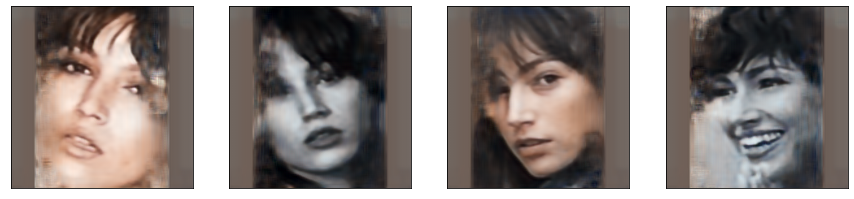

Actual Images


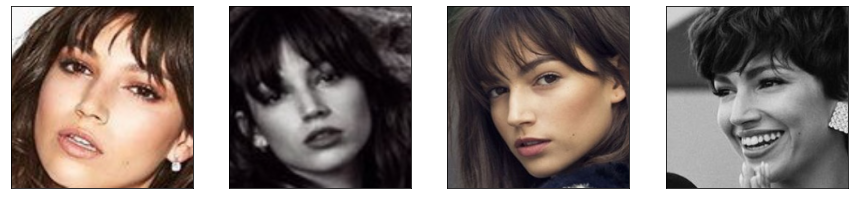

PSNR: 15.589529037475586
MSE: 0.02891034074127674
RMSE: 0.170030415058136
Cosine Similarity: 0.9870790839195251
Discriminator Prediction on Generator: 1.0
Discriminator Prediction on Actual: 1.0
Epoch 82/100
[========]  altered_MSE = 0.0325, Disc Loss = 7.6666, PSNR = 15.320, Test altered_MSE = 0.0350, Test Disc Loss = 7.6666, Test PSNR = 15.171 
Time per epoch: 00:10:50

Epoch 83/100
[========]  altered_MSE = 0.0316, Disc Loss = 7.6666, PSNR = 15.481, Test altered_MSE = 0.0346, Test Disc Loss = 7.6666, Test PSNR = 15.183 
Time per epoch: 00:10:48

Epoch 84/100
[========]  altered_MSE = 0.0312, Disc Loss = 7.6666, PSNR = 15.541, Test altered_MSE = 0.0349, Test Disc Loss = 7.6666, Test PSNR = 15.184 
Time per epoch: 00:10:49

Epoch 85/100
[========]  altered_MSE = 0.0309, Disc Loss = 7.6666, PSNR = 15.569, Test altered_MSE = 0.0345, Test Disc Loss = 7.6666, Test PSNR = 15.247 
Time per epoch: 00:10:50

Epoch 86/100
[========]  altered_MSE = 0.0310, Disc Loss = 7.6666, PSNR = 15.561, Tes

Log file loaded in the form of a dictionary
Test Images


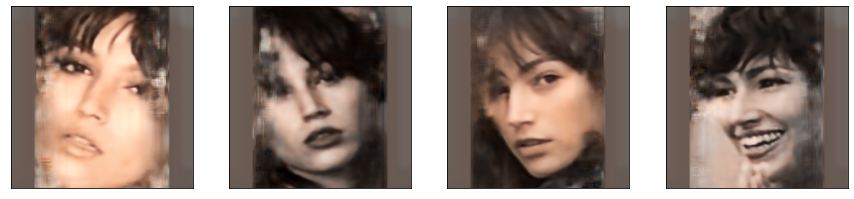

Actual Images


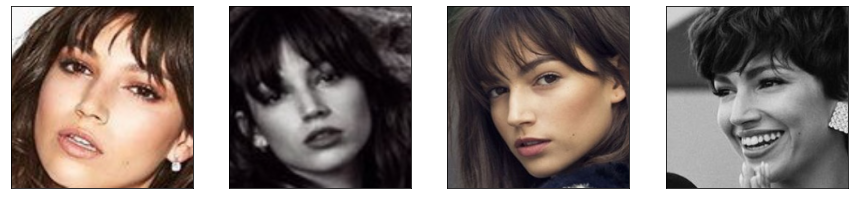

PSNR: 15.560213088989258
MSE: 0.029162883758544922
RMSE: 0.17077143490314484
Cosine Similarity: 0.9859458208084106
Discriminator Prediction on Generator: 1.0
Discriminator Prediction on Actual: 1.0
Epoch 92/100
[========]  altered_MSE = 0.0303, Disc Loss = 7.6666, PSNR = 15.679, Test altered_MSE = 0.0353, Test Disc Loss = 7.6666, Test PSNR = 15.094 
Time per epoch: 00:10:50

Epoch 93/100
[========]  altered_MSE = 0.0302, Disc Loss = 7.6666, PSNR = 15.678, Test altered_MSE = 0.0349, Test Disc Loss = 7.6666, Test PSNR = 15.135 
Time per epoch: 00:10:48

Epoch 94/100
[========]  altered_MSE = 0.0298, Disc Loss = 7.6666, PSNR = 15.723, Test altered_MSE = 0.0362, Test Disc Loss = 7.6666, Test PSNR = 15.015 
Time per epoch: 00:10:49

Epoch 95/100
[======

In [ ]:
# kwargs contain train_data = (masked_images, actual_images), test_data = (masked_test, actual_test),
#                    epochs, batch_size, 
#                    train_disc_after,
#                    loss=(gen_loss_function, disc_loss_function), 
#                    optimizer = (optimizer, optimizer),
#                    mask_compliment, accuracy_function,
#                    save_after, checkpoint_function,

train(gen_model, disc_model, 
      train_data=train_data,
      test_data = test_data,
      epochs=epochs, epochs_done=epochs_done, 
      train_disc_after=train_disc_after,
      batch_size=batch_size, 
      loss=(gen_loss, disc_loss), mse = mse_error,
      optimizer=(gen_optimizer, disc_optimizer), 
      mask_compliment=mask_compliment, 
      metric=accuracy_function,
      save_after=save_after, save_models=save_models,
      history=logs, save_logs=save_logs,
      plot_function=plot)

In [ ]:
# Run this cell only if the above cell is interrupted or threw some error
# Load the logs of the completely trained model
logs = load_logs(logfile_name='/content/logs_21epochs.pickle')

Log file loaded in the form of a dictionary


Generated Images


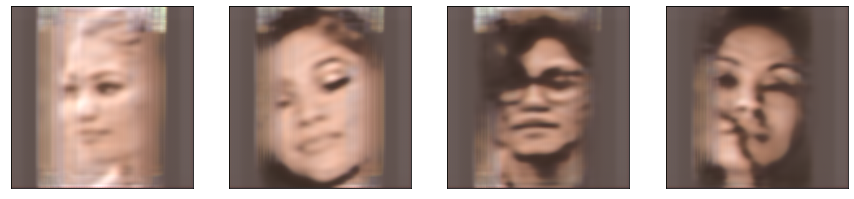

Masked Images


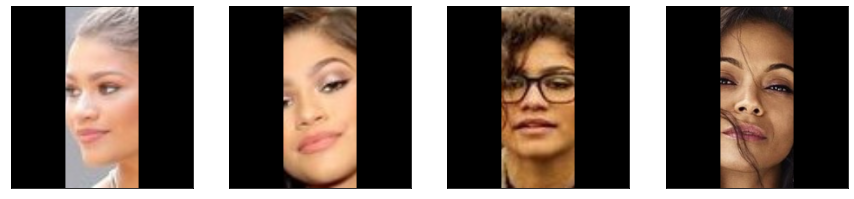

Actual Clear Images


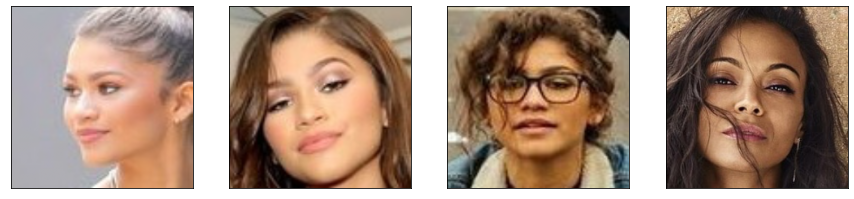

PSNR: 15.741597175598145
MSE: 0.026939421892166138
RMSE: 0.164132327297973
Cosine Similarity: 0.9855026602745056

Discriminator Prediction on Generator: 1.0
Discriminator Prediction on Actual: 1.0

Masked PSNR: 16.23968505859375
Masked mse: 0.02408584224914952
Masked RMSE: 0.15519614121861897
Masked Cosine Similarity: 0.5882209539413452


In [ ]:
# 0.0327
# start = np.random.randint(600, 626)
start = np.random.randint(600, 626)
count = 4
end = start + count
figsize = (15, 15)

validation_dataset, validate_mask = create_masked_images(images[start: end], percent_mask = 0.60, hide_axis=2)

gen_imgs = gen_model.predict(validation_dataset)

print("Generated Images")
plot(gen_imgs, figsize=figsize)

print("Masked Images")
plot(validation_dataset, figsize=figsize)

print("Actual Clear Images")
plot(images[start: end], figsize=figsize)

print(f"PSNR: {psnr(images[start: end], gen_imgs)}")
print(f"MSE: {mse(images[start: end], gen_imgs)}")
print(f'RMSE: {rmse(images[start: end], gen_imgs)}')
print(f'Cosine Similarity: {cosine_sim(images[start: end], gen_imgs)}')

print()
print(f'Discriminator Prediction on Generator: {tf.reduce_mean(disc_model.predict(gen_imgs))}')
print(f'Discriminator Prediction on Actual: {tf.reduce_mean(disc_model.predict(images[start: end]))}')

print()

# Metrics on masked images
print(f"Masked PSNR: {psnr((1-mask)*images[start: end], (1-mask)*gen_imgs)}")
print(f"Masked mse: {mse((1-mask)*images[start: end], (1-mask)*gen_imgs)}")
print(f'Masked RMSE: {rmse((1-mask)*images[start: end], (1-mask)*gen_imgs)}')
print(f'Masked Cosine Similarity: {cosine_sim((1-mask)*images[start: end], (1-mask)*gen_imgs)}')

In [ ]:
def plot_curve(train_data=None, validation_data=None, name='', xlabel='', ylabel=''):

    if train_data:
        plt.plot(train_data, label=f'Train {name}')
    
    if validation_data:
        plt.plot(validation_data, label=f'Test {name}')

    if xlabel:
        plt.xlabel(xlabel)
    
    if ylabel:
        plt.ylabel(ylabel)
    
    if name:
        plt.legend()

    plt.show()    

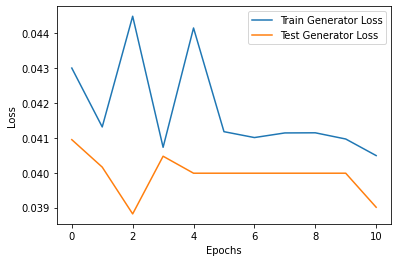

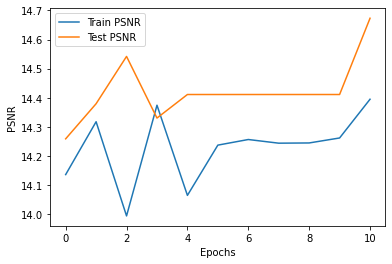

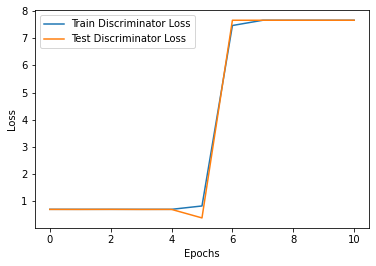

In [ ]:
# First 10 epoch data not shown because of higher values of loss and lower valus PSNR initially

plot_curve(logs['generator_loss'][10: ], logs['test_generator_loss'][10: ], name='Generator Loss', xlabel='Epochs', ylabel='Loss')
plot_curve(logs['psnr'][10: ], logs['test_psnr'][10: ], name='PSNR', xlabel='Epochs', ylabel='PSNR')
plot_curve(logs['discriminator_loss'][10: ], logs['test_discriminator_loss'][10: ], name='Discriminator Loss', xlabel='Epochs', ylabel='Loss')

In [ ]:
load_model('/Generator_100epochs.h5', custom_objects={'generator_loss':gen_loss})

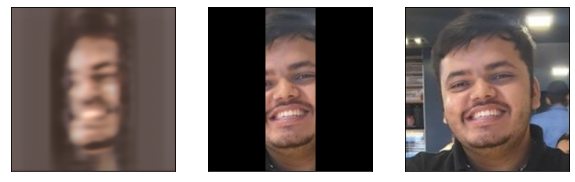

PSNR: 14.714552879333496
MSE: 0.033771056681871414
RMSE: 0.18376902419476127
Cosine Similarity: 0.992674708366394

Discriminator Prediction on Generator: 1.0
Discriminator Prediction on Actual: 1.0



In [ ]:
test_img = cv2.imread('/profile_pic.jpg')
test_img = cv2.cvtColor(cv2.resize(test_img, (224, 224)), cv2.COLOR_BGR2RGB)
test_img = np.reshape(test_img/255, (1, 224, 224, 3))
test_masked, test_mask = create_masked_images(test_img, percent_mask = 0.7, hide_axis=2)

test_figsize = (10, 10)
gen_test = gen_model.predict(test_masked)

plot([gen_test[0], test_masked[0], test_img[0]], figsize=test_figsize)


print(f"PSNR: {psnr(test_img, gen_test)}")
print(f"MSE: {mse(test_img, gen_test)}")
print(f'RMSE: {rmse(test_img, gen_test)}')
print(f'Cosine Similarity: {cosine_sim(test_img, gen_test)}')

print()
print(f'Discriminator Prediction on Generator: {tf.reduce_mean(disc_model.predict(gen_test))}')
print(f'Discriminator Prediction on Actual: {tf.reduce_mean(disc_model.predict(test_img))}')

print()